# Lecture 11 - Ensemble Learning

***
##### CS 434 - Data Mining and Machine Learning
##### Oregon State University-Cascades
***


## <img src="https://img.icons8.com/color/32/000000/fork-lift.png"/> Loading packages

In [0]:
import math
import operator
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pydotplus import graph_from_dot_data
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from scipy.special import comb
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.pipeline import _name_estimators
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from IPython.display import Image

### <img src="https://img.icons8.com/color/24/000000/cosine.png"/> Helper function for graphing our results

In [0]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

## <img src="https://img.icons8.com/color/32/000000/accept-database.png"/> Prepare a dataset

### <img src="https://img.icons8.com/color/32/000000/database-restore.png"/>  Load the data


Load the Iris dataset from scikit-learn.  Choose the first 50 examples.

In [0]:
# load iris dataset
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]

### <img src="https://img.icons8.com/color/32/000000/variation.png"/> Encode the class label

In [0]:
# encode labels
le = LabelEncoder()
y = le.fit_transform(y)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### <img src="https://img.icons8.com/color/32/000000/split-files.png"/> Split into train and test sets

In this example, 50% is for training and 50% is for testing.

In [0]:
# hold out split with 50% data as test
X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1,
                        stratify=y)
       
print('Label counts in y:', np.bincount(y))
print('Label counts in y_train:', np.bincount(y_train))
print('Label counts in y_test:', np.bincount(y_test))       

Label counts in y: [50 50]
Label counts in y_train: [25 25]
Label counts in y_test: [25 25]


# <img src="https://img.icons8.com/color/32/000000/teamwork.png"/> Ensemble Learning

The goal of ensemble methods is to combine different classifiers into a meta-classifier that has better generalization performance than each individual classifier alone. 

### <img src="https://img.icons8.com/color/32/000000/layers.png"/> Ensemble of models

Train $m$ different classifiers $(C_1, \ldots, C_m)$. In some techniques, the ensemble consists of different classification algorithms. In other techniques, the same classifier is used, but on different subsets of training data. 

![alt text](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch07/images/07_02.png?raw=true)

## <img src="https://img.icons8.com/color/32/000000/elections.png"/> Majority vote

### <img src="https://img.icons8.com/color/32/000000/poll-topic.png"/> Types of Voting

*Majority* - select the class label with at least 50% of the vote (binary classification)

*Plurality* - select the class label with the most votes (multiclass classification)

![alt text](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch07/images/07_01.png?raw=true)

### <img src="https://img.icons8.com/color/32/000000/formula-fx.png"/> Formula

$$\hat{y} = \text{mode}\{C_1(\bf{x}),C_2(\bf{x}), \ldots, C_m(\bf{x})\}$$
where $\text{mode}$ is the most frequent value in the set.

For example, in a binary classification task where `class1 = -1` and `class2 = +1`, the majority vote is written as

$$C(\textbf{x}) = \text{sign} \left[ \sum_j^m C_j(\textbf{x})\right] = \begin{cases} 
      1 & \text{if}\ \ \sum_j C_j(\mathbf{x}) \ge 0\\
      -1 & \text{otherwise} 
   \end{cases}
$$

## <img src="https://img.icons8.com/color/32/000000/error.png"/> Error probability

 Compute the probability that the prediction of the ensemble is wrong.

 $$P(y \ge k) = \sum_k^n \genfrac\langle\rangle{0pt}{2}{n}{k} \ \epsilon^k(1-\epsilon)^{n-k} = \epsilon_{\text{ensemble}} $$

where $\genfrac\langle\rangle{0pt}{2}{n}{k}$ is the binomial coefficient `n choose k`. 

 ### <img src="https://img.icons8.com/color/32/000000/new-document.png"/> Example

Consider an example with $n=11$ base classifiers, where each classifier has an error rate of 0.25 ($\epsilon=0.25)$


 
 $$P(y \ge k) = \sum_{k=6}^{11} \genfrac\langle\rangle{0pt}{2}{11}{k} \ 0.25^k(1-0.25)^{11-k} = 0.034 $$


The error rate of teh ensemble ($0.034$) is much lower than the error of each individual classifier (0.25), if all the assumptions are met.

In [0]:
# error function
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [0]:
# calculate error
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

### <img src="https://img.icons8.com/color/32/000000/statistics.png"/>  Plot error

In [0]:
# error values
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

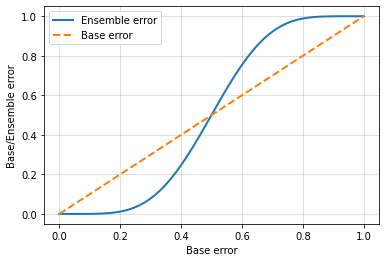

In [0]:
# visualize ensemble and base error
plt.plot(error_range, 
         ens_errors, 
         label='Ensemble error', 
         linewidth=2)

plt.plot(error_range, 
         error_range, 
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

# <img src="https://img.icons8.com/color/32/000000/plus-math.png"/> Combine classifiers with majority vote

We can write a weighted majority vote as follows:

$$ \hat{y} = \arg \max_i \sum_{j=1}^m w_j \ \chi_A \ (C_j(\mathbf{x}) = i) $$

where:
* $w_j$ is a weight associated with a base classifier: $C_j$
* $\hat{y}$ is the predicted class label of the ensemble
* $\chi_A$ is the characteristic function, which returns 1 if the predicted class of the $j$th classifier match $i$ ($C_j \ (\bf{x})=i$)

With equal weights, we simplify:
$$\hat{y} = \text{mode}\{C_1(\bf{x}),C_2(\bf{x}), \ldots, C_m(\bf{x})\}$$

### <img src="https://img.icons8.com/color/32/000000/new-document.png"/> Example

In [0]:
# majority voting with weights
np.argmax(np.bincount([0, 0, 1], 
                      weights=[0.2, 0.2, 0.6]))

1

In [0]:
# majority voting with probabilities
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, 
               axis=0, 
               weights=[0.2, 0.2, 0.6])
print(p)
print()
print(np.argmax(p))

[0.58 0.42]

0


## <img src="https://img.icons8.com/color/32/000000/serial-tasks.png"/> Implementation

### <img src="https://img.icons8.com/color/32/000000/code.png"/> Define a `MajorityVoteClassifier`

In [0]:
class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

### <img src="https://img.icons8.com/color/32/000000/3.png"/> Compare three classifiers

In [0]:
# define and test three classifiers
clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


### <img src="https://img.icons8.com/color/32/000000/checked-checkbox.png"/> Apply the `MajorityVoteClassifier`

In [0]:
# majority rule (hard) voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


### <img src="https://img.icons8.com/color/32/000000/report-card.png"/> Evaluate the ensemble classifier

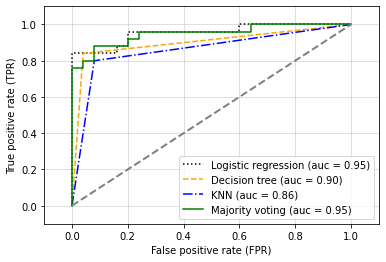

In [0]:
# graph FPR vs TPR
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

### <img src="https://img.icons8.com/color/32/000000/presentation.png"/>  Visualize the ensemble classifier

In [0]:
# standardize (for visualization)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

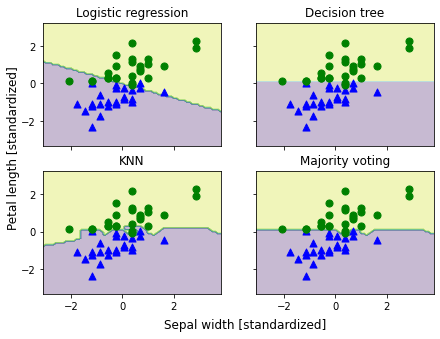

In [0]:
# visualization 
all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.show()

### <img src="https://img.icons8.com/color/32/000000/ingredients-list.png"/> View model parameters

In [0]:
# get params
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=0, splitter='best'),
 'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'de

### <img src="https://img.icons8.com/color/32/000000/horizontal-settings-mixer.png"/> Tune model parameters

In [0]:
# model parameters to check
params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

# grid search
grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    iid=False,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=10, error_score=nan,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
                                                                    steps=[('sc',
                                                                            StandardScaler(copy=True,
                                                                                           with_mean=True,
                                                                                           with_std=True)),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               class_weight=None,
                                                                                               dual=False,
                                                                           

In [0]:
# enumerate the CV results
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [0]:
# print best paramters and accuracy
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
Accuracy: 0.98


**Note**  
By default, the default setting for `refit` in `GridSearchCV` is `True` (i.e., `GridSeachCV(..., refit=True)`), which means that we can use the fitted `GridSearchCV` estimator to make predictions via the `predict` method, for example:

    grid = GridSearchCV(estimator=mv_clf, 
                        param_grid=params, 
                        cv=10, 
                        scoring='roc_auc')
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

In addition, the "best" estimator can directly be accessed via the `best_estimator_` attribute.

In [0]:
# view best estimator
grid.best_estimator_.classifiers

[Pipeline(memory=None,
          steps=[('sc',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ['clf',
                  LogisticRegression(C=0.001, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=1,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False)]],
          verbose=False),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_f

In [0]:
# get best estimator
mv_clf = grid.best_estimator_

In [0]:
# set parameters of majority vote
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
                                             steps=[('sc',
                                                     StandardScaler(copy=True,
                                                                    with_mean=True,
                                                                    with_std=True)),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                               

In [0]:
# view the classifier
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
                                             steps=[('sc',
                                                     StandardScaler(copy=True,
                                                                    with_mean=True,
                                                                    with_std=True)),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                               

<br>
<br>

# <img src="https://img.icons8.com/color/32/000000/forest.png"/> Random Forests

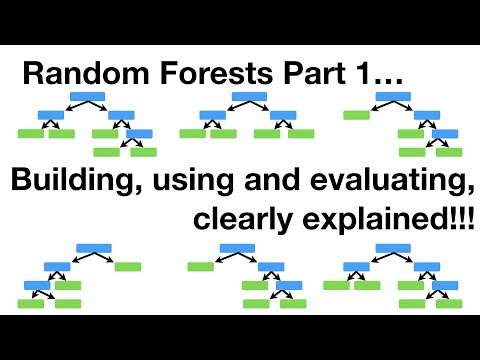

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('J4Wdy0Wc_xQ')

### <img src="https://img.icons8.com/color/32/000000/restart--v1.png"/> Reload dataset

In [0]:
# load iris
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

# split X and y
X = iris.data[:, [2, 3]]
y = iris.target

# train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

# standardize
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# needed for graphing
X_combined = np.vstack((X_train, X_test))
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

## <img src="https://img.icons8.com/color/32/000000/active-directory.png"/> Random Forests with `sklearn`

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


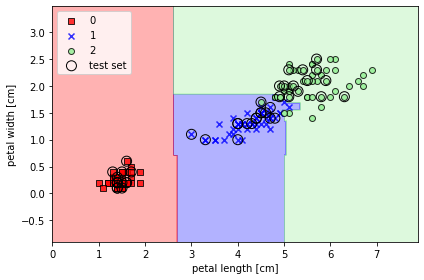

In [0]:
# train a random forest
forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Regression trees

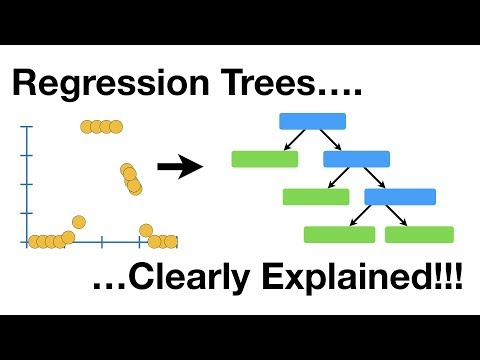

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('g9c66TUylZ4')